In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import xarray as xr
import matplotlib.patches as mpatches
import os
from lib import conversion
import matplotlib.lines as mlines
import stageemi.dev.geojson_shapefile as geojson_shapefile
from mpl_toolkits.axes_grid1 import make_axes_locatable

import stageemi.dev.geojson_geoview as gv

In [2]:
def get_legend(code_compas, code_compas_asym, code_agat_asym, code_agat):
    file_CodesWWMF = '../utils/CodesWWMF.csv'
    df2             = pd.read_csv(file_CodesWWMF,sep=',')
    Code_WME       = df2['Code WME'].to_numpy()
    Code_WWMF      = df2['Code WWMF'].to_numpy()
    Code_W1        = df2['Code W1'].to_numpy()
    legende_WWMF   = df2['Legende WWMF'].to_numpy()
    legende_WME    = df2['Legende WME'].to_numpy()
    legende_W1     = df2['Legende W1'].to_numpy()

    leg_compas = np.unique(legende_WME[Code_WME==code_compas])[0]
    leg_compas_asym = np.unique(legende_WME[Code_WME==code_compas_asym])[0]
    leg_agat_asym = np.unique(legende_W1[Code_W1==code_agat_asym])[0]
    leg_agat      = np.unique(legende_W1[Code_W1==code_agat])[0]
    return(leg_compas,leg_compas_asym,leg_agat_asym,leg_agat)

def  get_color(code_compas, code_compas_asym, code_agat_asym, code_agat,newcolors_agat, newcolors_compas):
    df2             = pd.read_csv(file_CodesWWMF,sep=',')
    Code_WME       = np.unique(df2['Code WME'].to_numpy())
    Code_WWMF      = np.unique(df2['Code WWMF'].to_numpy())
    Code_W1        = np.unique(df2['Code W1'].to_numpy())
    legende_WWMF   = np.unique(df2['Legende WWMF'].to_numpy())
    legende_WME    = np.unique(df2['Legende WME'].to_numpy())
    legende_W1     = np.unique(df2['Legende W1'].to_numpy())

    compas_color = newcolors_compas.values[Code_WME==code_compas][0]
    compas_asym_color = newcolors_compas.values[Code_WME==code_compas_asym][0]
    agat_color = newcolors_agat.values[Code_W1==code_agat][0]
    agat_asym_color = newcolors_agat.values[Code_W1==code_agat_asym][0]
    
    return(compas_color, compas_asym_color,agat_asym_color ,agat_color ) 

In [18]:
plt.rcParams.update({'font.size': 18})

def generate_plot(var2plot,fname_out,handles,variable="WME"):
    import matplotlib as mpl
#     variable = "WME"
    file_CodesWWMF =  '../utils/CodesWWMF.csv'    
    df = pd.read_csv(file_CodesWWMF,usecols = (0,1,2,3,6,7),sep=',') 
    if variable == "WME":
        df_crop = df[["Code WME","Legende WME"]].set_index("Code WME").drop_duplicates().rename(columns={"Legende WME":"Legende"})     
    elif variable == "WME":
        df_crop = df[["Code WME","Legende WME"]].set_index("Code WME").drop_duplicates().rename(columns={"Legende WME":"Legende"})
    elif variable == "W1":
        df_crop = df[["Code W1","Legende W1"]].set_index("Code W1").drop_duplicates().rename(columns={"Legende W1":"Legende"})       
    N = df_crop.size
    newcolors, newcolors_rgb = gv.colorbar_definition_wwmf(N,'viridis',variable = variable)
    newcmp = matplotlib.colors.ListedColormap(newcolors.values)
    l_bounds = (df_crop.index -0.5).to_list() #(df_crop.index*1.0).to_list()
    l_bounds.sort()
    l_bounds.append(df_crop.index.max() + 1)
    norm = matplotlib.colors.BoundaryNorm(l_bounds, newcmp.N)
    fig = plt.figure(figsize  = (15,10))
#     fig,ax = plt.figure(nrows=1,ncols=1,figsize  = (15,10),projection=ccrs.PlateCarree())
    try:
        import cartopy.crs as ccrs
        import cartopy.feature as cfeature
#         print('ici')
        ax = plt.axes(projection=ccrs.PlateCarree())
        cax = fig.add_axes([ax.get_position().x1*1.2,ax.get_position().y0*1.3 ,0.03,0.7])

#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes("right", size="5%", pad=0.05,map_projection=ccrs.PlateCarree())
        use_cartopy = True 
    except Exception as e: 
        ax = plt.axes()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        use_cartopy = False
        print("Cartopy is not installed")
    if isinstance(var2plot,xr.core.dataarray.DataArray):
        var2plot.plot.imshow(ax=ax,cmap=newcmp,norm=norm,add_colorbar=False)
    else:
        ax.imshow(var2plot,cmap=newcmp,norm=norm)
    if use_cartopy: 
        ax.coastlines(resolution='50m', color='white', linewidth=1)
        ax.add_feature(cfeature.BORDERS.with_scale('50m'),edgecolor='white')
        ax.gridlines(draw_labels=True)
    ax.set_title('')    
    bounds = np.linspace(0,N,N+1)
    ticks_new = bounds[:-1]+0.5 
    cb = mpl.colorbar.ColorbarBase(cax,cmap=newcmp,boundaries=bounds,ticks=ticks_new)
    cb.ax.set_yticklabels(df_crop.Legende.to_list())
    cb.ax.tick_params(labelsize=16)
    leg = ax.legend(handles=handles, bbox_to_anchor=(0.5, 1.02),
                        loc='lower center',labelspacing =2,fontsize = 24,
                             handlelength=0, handletextpad=0, fancybox=True)
    for line, text in zip(leg.get_lines(), leg.get_texts()):
        text.set_color(line.get_color())
#     fig.tight_layout()
    fig.savefig(fname_out,bbox_inches='tight',dpi=400)
#generate_plot(var2plot)


In [4]:
date= '2020012600'
dep_id = '34'
echeance = 1
index_zone = 0
dir_fig = '../figures/agregation/'
dir_csv = '../zonageWME/'
file_CodesWWMF = '../utils/CodesWWMF.csv'


""" lecture arome """
fname = "../WWMF/" + date+'0000__PG0PAROME__'+'WWMF'+'__EURW1S100______GRILLE____0_48_1__SOL____GRIB2.nc'
ds = xr.open_dataset(fname,chunks={"step":1}).isel(step = echeance)
ds['latitude']  = ds['latitude'].round(5)
ds['longitude'] = ds['longitude'].round(5)

"""lecture masque"""
fname_out            = '../GeoData/zones_sympo_multiples/'+dep_id+'_mask_zones_sympos.nc'
ds_mask              = xr.open_dataset(fname_out)
ds_mask["latitude"]  = ds_mask["latitude"].round(5)
ds_mask["longitude"] = ds_mask["longitude"].round(5)

"""lecture fichier resultats"""
fname_csv_ini = dir_csv+ 'v2_'+dep_id+'_'+date+'_'+str(echeance)+'.csv'
df            = pd.read_csv(fname_csv_ini)
id_zone       = df.iloc[index_zone]['zone']
ds_dep_tot    = (ds*ds_mask.mask.sel(id=id_zone).drop("id"))

if date == '2020030600':
    ds_dep_tot = ds_dep_tot.rename({'paramId_0':'unknown'})
    
ds_dep_tot = conversion (ds_dep_tot,"compas") 
ds_dep_tot = conversion (ds_dep_tot,"agat") 

In [5]:

# ds_dep_tot

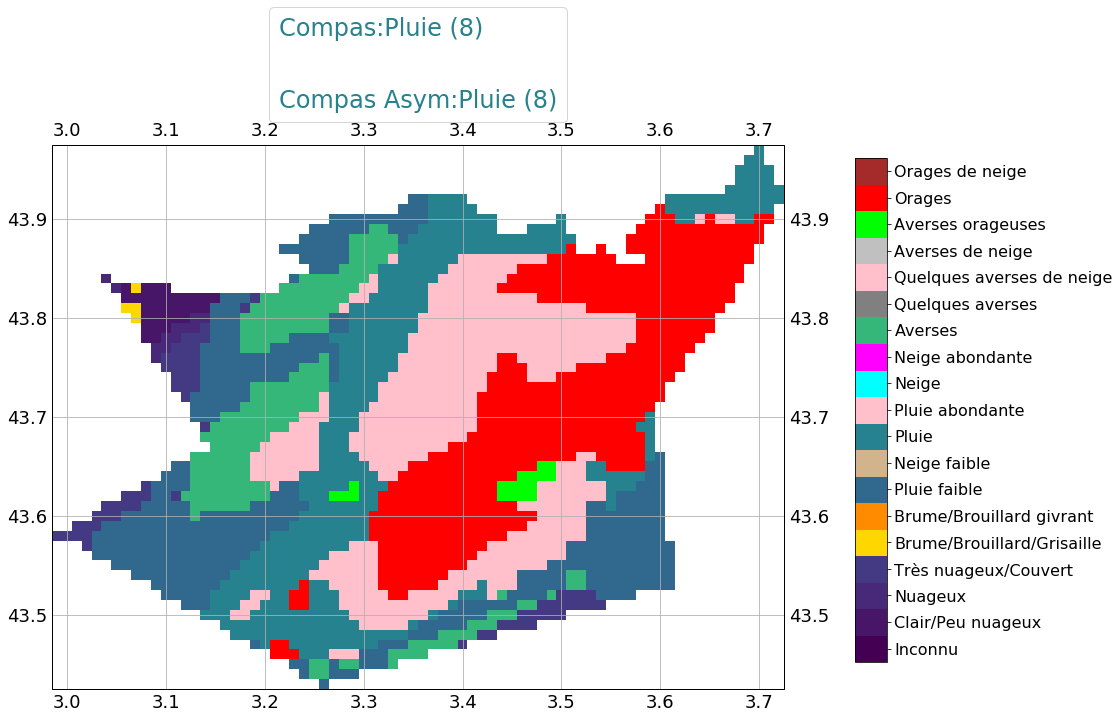

In [19]:
newcolors_agat, newcolors_rgb = geojson_shapefile.colorbar_definition_wwmf(25,'viridis',variable = 'W1')
newcolors_compas, newcolors_rgb = geojson_shapefile.colorbar_definition_wwmf(19,'viridis',variable = 'WME')

varname = 'wme_arr' # variable à ploter

leg_compas,leg_compas_asym,leg_agat_asym,leg_agat = get_legend(df.iloc[index_zone]['compas'], 
                                df.iloc[index_zone]['compas_asym'], df.iloc[index_zone]['agat_asym'], df.iloc[index_zone]['agat'])
compas_color, compas_asym_color,agat_asym_color ,agat_color = get_color(df.iloc[index_zone]['compas'],  
                                df.iloc[index_zone]['compas_asym'], df.iloc[index_zone]['agat_asym'], 
                                df.iloc[index_zone]['agat'],newcolors_agat, newcolors_compas)
for varname in ['wme_arr']:#,'w1_arr']:
    if varname == 'wme_arr':
        variable = "WME"
        handles = [ mlines.Line2D([], [], color=compas_color,
                        label= 'Compas:{} ({})'.format(leg_compas,df.iloc[index_zone]['compas'])),
               mlines.Line2D([], [], color=compas_asym_color,
                        label= 'Compas Asym:{} ({})'.format(leg_compas_asym,df.iloc[index_zone]['compas_asym'])) 
        ]
    elif varname == 'w1_arr':
        variable = 'W1'
        handles = [mlines.Line2D([], [], color=agat_color,
                                label= 'Agat:{} ({})'.format(leg_agat,df.iloc[index_zone]['agat'])),                            
                     mlines.Line2D([], [], color=agat_asym_color,
                                label= 'Agat Asym:{} ({})'.format(leg_agat_asym,df.iloc[index_zone]['agat_asym']))        
        ]
        
    fname_out = dir_fig+'v4_'+dep_id+'_'+date+'_'+str(echeance)+'_'+str(index_zone)+'_'+variable+'.png'
    var2plot=ds_dep_tot[varname].where(ds_mask.mask.sel(id=id_zone)==1,drop=True)
    generate_plot(var2plot,fname_out,handles,variable=variable)